In [103]:
# coding: utf-8
# Author: Vinay Chourasiya

import time
start_time = time.time()
from math import sin, cos, sqrt, atan2, radians
import sys
from scipy.spatial.distance import pdist, squareform
import numpy as np

class ReadData():
    def __init__(self, filename):

        self.name = filename[:-4]
        self.size = self.getSize()
        self.EdgeWeightType = self.getEdgeWeightType()
        self.format_ = self.getFormat()  # for EXPLICIT data only
        self.time_to_read = 0

    def getFormat(self):
        format_ = "None"
        try:
            with open(f'/content/att48.tsp') as data:
                datalist = data.read().split()
                for ind, elem in enumerate(datalist):
                    if elem == "EDGE_WEIGHT_FORMAT:":
                        format_ = datalist[ind + 1]
                        break
                    elif elem == "EDGE_WEIGHT_FORMAT":
                        format_ = datalist[ind + 2]
                        break
            return format_

        except IOError:
            print("Input file not found")
            sys.exit(1)

    def getEdgeWeightType(self):
        EdgeType = "None"
        try:
            with open(f'/content/att48.tsp') as data:
                datalist = data.read().split()
                for ind, elem in enumerate(datalist):
                    if elem == "EDGE_WEIGHT_TYPE:":
                        EdgeType = datalist[ind + 1]
                        #print(EdgeType)
                        break
                    elif elem == "EDGE_WEIGHT_TYPE":
                        EdgeType = datalist[ind + 2]
                        #print(EdgeType)
                        break
            return EdgeType

        except IOError:
            print("Input file not found")
            sys.exit(1)

    def getSize(self):
        """
        Return size of instances (i.e. Number of
        cities)
        
        """
        size = 0
        try:
            with open(f'/content/att48.tsp') as data:
                datalist = data.read().split()
                for ind, elem in enumerate(datalist):
                    if elem == "DIMENSION:":
                        size = datalist[ind + 1]
                        #print(size)
                        break
                    elif elem == "DIMENSION":
                        size = datalist[ind + 2]
                        #print(size)
                        break
            return int(size)
        except IOError:
            print("Input file not found")
            sys.exit(1)

    def read_Data(self):
        with open(f'/content/att48.tsp') as data:
            cities = []
            Isdata = True
            while (Isdata):
                line = data.readline().split()
                if len(line) <= 0:
                    break
                tempcity = []
                for i, elem in enumerate(line):
                    try:
                        temp = float(elem)
                        tempcity.append(temp)
                    except ValueError:
                        break
                if len(tempcity) > 0:
                    cities.append(np.array(tempcity))
        return np.array(cities)

    def GetDistanceMat(self):
        if self.EdgeWeightType == "EXPLICIT":
            DistanceMat = self.getMat()
            self.time_to_read = time.time() - start_time
            return DistanceMat
        elif self.EdgeWeightType == "EUC_2D" or "CEIL_2D":
            DistanceMat = self.EuclidDist()
            self.time_to_read = time.time() - start_time
            return DistanceMat
        elif self.EdgeWeightType == "GEO":
            DistanceMat = self.GeographicDist()
            self.time_to_read = time.time() - start_time
            return DistanceMat
        else:
            return None

    def EuclidDist(self):
        cities = self.read_Data()
        #DistanceDict = {}
        A = cities[:, 1:3]
        DistanceMat = np.round(squareform(pdist(A)))
        return DistanceMat

    def GeographicDist(self):
        a = time.time()
        R = 6373.0
        cities = self.read_Data()
        DistanceMat = np.zeros((self.size, self.size))
        for i in range(self.size):
            for j in range(0, i + 1):
                node1 = cities[i]
                node2 = cities[j]
                lat1 = radians(node1[1])
                lat1 = radians(node1[1])
                lon1 = radians(node1[2])
                lat2 = radians(node2[1])
                lon2 = radians(node2[2])
                dlon = lon2 - lon1
                dlat = lat2 - lat1
                a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))
                distance = R * c
                DistanceMat[i, j] = distance
                DistanceMat[j, i] = distance
        
        return DistanceMat

    def getMat(self):
        DataFormat = self.getFormat()
        if DataFormat == "FULL_MATRIX":
            cities = self.read_Data()
            DistanceMat = cities[:self.size]
            return DistanceMat

        elif DataFormat == "LOWER_DIAG_ROW":
            with open(f'/content/att48.tsp') as file:
                indicator = False
                data = file.read().split()
                templist = []
                cities = []
                for elem in data:
                    if elem == "EDGE_WEIGHT_SECTION":
                        indicator = True
                        continue
                    if indicator:
                        try:
                            it = float(elem)
                            templist.append(it)
                        except:
                            break
                        if it == 0:
                            cities.append(templist)
                            templist = []
                DistanceMat = np.zeros((self.size, self.size))
                for i in range(self.size):
                    temp = []
                    l = len(cities[i])
                    for j in range(self.size):
                        if j <= (l - 1):
                            temp.append(cities[i][j])
                        else:
                            temp.append(cities[j][i])
                    DistanceMat[i] = temp
                return DistanceMat
        elif DataFormat == "UPPER_DIAG_ROW":
            with open(f'/content/att48.tsp') as file:
                indicator = False
                data = file.read().split()
                templist = []
                cities = []
                for elem in data:
                    if elem == "EDGE_WEIGHT_SECTION":
                        indicator = True
                        continue
                    if indicator:
                        try:
                            it = float(elem)
                            templist.append(it)
                        except ValueError:
                            break
                        if it == 0:
                            cities.append(templist)
                            templist = []
                print("Need to complete it")
        else:
            sys.exit("No Format Match for EXPLICIT data")

In [104]:
import matplotlib.pyplot as plt

def plotTSP(paths, points, num_iters=1):

    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list

    """

    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = 'r',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(min(x)*1.1, max(x)*1.1)
    plt.ylim(min(y)*1.1, max(y)*1.1)
    plt.show()

In [105]:
# coding: utf-8
# Author: Vinay Chourasiya

import time
start_time = time.time()
import numpy as np
import sys 

class TwoOPT:
    """
    2-opt:
          Generate intial tour
          and improve it by deleting 1 one edges
          and change with other
    -- It gives nearly optimal tour    
    """

    def __init__(self, file):
        """
            Intialize: Instaces file,
                       Distance Matrix,
                       and size
        """
        self.file = file
        self.instance = ReadData(self.file)
        self.size = self.instance.size
        self.dis_mat = self.instance.GetDistanceMat()
        self.time_read = self.instance.time_to_read
        self.time_algo = 0

    def get_initial_tour(self):
        """
        Return: intial tour
        """
        return [*range(1, self.size + 1)]

    def Swap(self, tour, x, y):
        """
            tour : Given TSP tour
            x = swappping First index in tour 
            y = swappping last index in tour
            return : new_tour with perfomming swapping 
            note: x and y should be index only (in tour) not exact city number
        """
        new_tour = tour[:x] + [*reversed(tour[x:y + 1])] + tour[y + 1:]
        return new_tour

    def get_distance(self, tour):
        """
        Given any tour it return total distance of
        given tour
        dis_mat : distance matrix 
        """
        total_dis = 0
        for ind, r in enumerate(tour):
            _from = r
            if ind + 1 == len(tour):
                _to = tour[0]
                total_dis += self.dis_mat[_from - 1][_to - 1]
            else:
                _to = tour[ind + 1]
                total_dis += self.dis_mat[_from - 1][_to - 1]
        return total_dis

    def _optimize(self, initial_tour, Debuglevel=0):
        """
            Improve existing tour 
            using 2-opt method
        """
        minchange = -1
        tour = initial_tour
        while minchange < 0:
            minchange = 0
            for i in range(self.size - 3):
                for j in range(i + 2, self.size - 1):
                    t1 = tour[i]
                    t2 = tour[i + 1]
                    t3 = tour[j]
                    t4 = tour[j + 1]

                    change = (self.dis_mat[t1 - 1][t3 - 1] +
                              self.dis_mat[t2 - 1][t4 - 1] -
                              self.dis_mat[t1 - 1][t2 - 1] -
                              self.dis_mat[t3 - 1][t4 - 1])
                    if change < minchange:
                        minchange = change
                        tour = self.Swap(tour, i + 1, j)
            if Debuglevel:
                print("Tour After Change : ", minchange, "Distances: ",
                      self.get_distance(tour))
        self.best_tour = tour
        return tour

    def _initial_random_tour(self,seed):
        """"
        Return randomly generated tour
        """
        np.random.seed(seed)
        T = np.arange(1,self.size+1)
        np.random.shuffle(T)
        return list(T)

    def run(self):
        tours = []
        tours_dist = []
        #self._write_info()
        for r in range(1):
            T = self._initial_random_tour(r)
            tour = self._optimize(T)
            tour_distance = self.get_distance(tour)
            tours.append(tour)
            tours_dist.append(tour_distance)

        min_dist_index = np.argmin(tours_dist)
        return (tours_dist[min_dist_index], tours[min_dist_index])
        

    def _write_info(self):
        print("Instance name:", self.instance.name)
        print("Dimention:", self.size)
        print("Distance Type:", self.instance.EdgeWeightType)
        print("\n \t \t Running 2-opt over 50 random tour ")

    def _writestat(self,D,T):
        print("\n Tour Distance: ",D)
        print(" Best Tour by 2-opt is: \n", T)
        print("\n Time to read instance (sec): ", round(self.time_read))
        self.time_algo = time.time() - start_time
        print(" Time to run instances(sec): ", round(self.time_algo))
        print(" Total Time (sec): ", round(self.time_read+self.time_algo))

"""
if len(sys.argv)<2:
	print("need inpute file")
	sys.exit(1)
t = TwoOPT(sys.argv[1])
t.run()	
"""

'\nif len(sys.argv)<2:\n\tprint("need inpute file")\n\tsys.exit(1)\nt = TwoOPT(sys.argv[1])\nt.run()\t\n'

In [106]:
import math
import random
import networkx as nx
import matplotlib.pyplot as plt
from copy import copy


class SimAnneal(object):
    def __init__(self, coords,filename,T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        self.coords = coords
        self.N = len(coords)
        self.T = math.sqrt(self.N) if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
        #Decrease in temperature
        self.alpha = 0.8 if alpha == -1 else alpha
        #Stopping temperature
        self.stopping_temperature = 1e-8 if stopping_T == -1 else stopping_T
        #Stopping iteration count
        self.stopping_iter = 1000000 if stopping_iter == -1 else stopping_iter
        #Iteration number count
        self.iteration = 1

        #Index of nodes
        self.nodes = [(i+1) for i in range(self.N)]

        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []
        self.filename = filename

    #Nearest neighbour start
    def initial_solution(self):
        
        #Greedy algorithm to get an initial solution (closest-neighbour).
        
        cur_node = random.choice(self.nodes)  # start from a random node
        solution = [cur_node]

        # get nodes other than current node
        free_nodes = set(self.nodes)
        free_nodes.remove(cur_node)
        
        
        while free_nodes:
            #print(cur_node)
            min_ = 1000000
            for j in free_nodes:
                if (self.coords[cur_node-1,j-1]<min_):
                    min_ = self.coords[cur_node-1,j-1]
                    node = j
            free_nodes.remove(node)
            #print(free_nodes)
            solution.append(node)
            #print(solution)
            cur_node = node
            
            
        cur_fit = self.fitness(solution)
        if cur_fit < self.best_fitness:  # If best found so far, update best fitness
            self.best_fitness = cur_fit
            self.best_solution = solution
        self.fitness_list.append(cur_fit)
        return solution, cur_fit
    #Nearest neighbour end
       
    #Random allocation
    def initial_solution(self):
        solution = copy(self.nodes)
        random.shuffle(solution)
        
        cur_fit = self.fitness(solution)
        if cur_fit < self.best_fitness:  # If best found so far, update best fitness
            self.best_fitness = cur_fit
            self.best_solution = solution
        self.fitness_list.append(cur_fit)
        return (solution, cur_fit)
    #Random alloc
    def initial_solution(self):
        L = TwoOPT(self.filename)
        cur_fit, solution = L.run()
        return (solution, cur_fit)
        

    
    
    def fitness(self, solution):
        
        #Total distance of the current solution path.
        
        cur_fit = 0
        for i in range(self.N - 1):
            #print(solution[i],solution[i+1])
            cur_fit += self.coords[solution[i]-1,solution[i+1]-1]
        #print(solution[i+1],solution[0])
        # Add the cost from last node back to initial node
        cur_fit += self.coords[solution[i+1]-1,solution[0]-1]
        return cur_fit

    def p_accept(self, candidate_fitness):
        
        #Probability of accepting if the candidate is worse than current.
        #Depends on the current temperature and difference between candidate and current.
        
        return 1/(1 + math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T))

    def accept(self, candidate):
        
        #Accept with probability 1 if candidate is better than current.
        #Accept with probabilty p_accept(..) if candidate is worse.
        
        candidate_fitness = self.fitness(candidate)
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness, self.cur_solution = candidate_fitness, candidate
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_solution = candidate_fitness, candidate
        else:
            if random.random() > self.p_accept(candidate_fitness):
                self.cur_fitness, self.cur_solution = candidate_fitness, candidate

    def Swap(self, tour, x, y):
        """:
            tour : Given TSP tour
            x = swappping First index in tour 
            y = swappping last index in tour
            return : new_tour with perfomming swapping 
            note: x and y should be index only (in tour) not exact city number
        """
        new_tour = tour[:x] + [*reversed(tour[x:y + 1])] + tour[y + 1:]
        return new_tour
    
    def _optimize(self, initial_tour):
        """
            Improve existing tour 
            using 2-opt method
        """
        minchange = -1
        tour = initial_tour
        while minchange < 0:
            minchange = 0
            for i in range(self.N - 3):
                for j in range(i + 2, self.N - 1):
                    t1 = tour[i]
                    t2 = tour[i + 1]
                    t3 = tour[j]
                    t4 = tour[j + 1]

                    change = (self.coords[t1 - 1][t3 - 1] +
                              self.coords[t2 - 1][t4 - 1] -
                              self.coords[t1 - 1][t2 - 1] -
                              self.coords[t3 - 1][t4 - 1])
                    if change < minchange:
                        minchange = change
                        tour = self.Swap(tour, i + 1, j)
        return tour
    
    def anneal(self):
        
        #Execute simulated annealing algorithm.
        
        # Initialize with the greedy solution.
        # Get value for current solution and fittness from greedy algo
        
        self.cur_solution, self.cur_fitness = self.initial_solution()

        print("Starting annealing.")
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
            candidate = list(self.cur_solution)
            
            #get a random no. from 2 to N-1(index of last node), both included
            # This number of values to be reversed
            l = random.randint(2, self.N - 1)
            #This is the index from where reversing starts i.e. 
            # from 0 N- l as l after values will be reversed
            i = random.randint(0, self.N - l)
            
            # Reverse the value of list from index i to i+l-1
            candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
            candidate = self._optimize(candidate)
            self.accept(candidate)
            self.T *= self.alpha
            self.iteration += 1

            self.fitness_list.append(self.cur_fitness)
        
        print(self.best_solution)
        print("Best fitness obtained: ", self.best_fitness)
        improvement = 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])
        print(f"Improvement over random allocation: {improvement : .2f}%")
        print(self.iteration)

    def batch_anneal(self, times=10000):
        
        #Execute simulated annealing algorithm `times` times, with random initial solutions.
        for i in range(1, times + 1):
            print(f"Iteration {i}/{times} -------------------------------")
            self.T = self.T_save
            self.iteration = 1
            self.cur_solution, self.cur_fitness = self.initial_solution()
            self.anneal()

    def visualize_routes(self):
        
        #Visualize the TSP route with matplotlib.
        G = nx.Graph()
        G.add_edges_from(self.best_solution)
        nx.draw(G,with_labels=True, nodecolor='r', edge_color='b')
        plt.show()

    def plot_learning(self):
        
        #Plot the fitness through iterations.
        
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel("Fitness")
        plt.xlabel("Iteration")
        plt.show() 


Starting annealing.
[4, 35, 45, 10, 24, 32, 39, 21, 13, 47, 20, 33, 46, 36, 30, 43, 17, 27, 19, 37, 6, 28, 7, 18, 44, 31, 38, 8, 1, 9, 40, 15, 12, 11, 23, 3, 22, 16, 41, 34, 14, 25, 48, 5, 29, 2, 42, 26]
Best fitness obtained:  33715.0
Improvement over random allocation:  14.65%
93


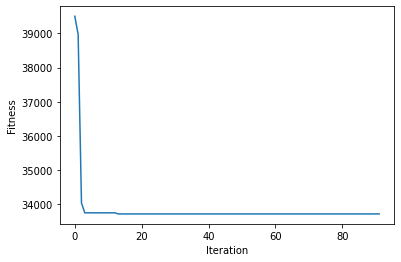

In [107]:
if len(sys.argv)<2:
	print("need inpute file")
	sys.exit(1)
filename = sys.argv[1]
D = ReadData(filename)

if __name__ == "__main__":
    # coords = [[random.uniform(-1000, 1000), random.uniform(-1000, 1000)] for i in range(100)]
    sa = SimAnneal(D.GetDistanceMat(),filename)#, stopping_iter=2)
    sa.anneal()
    #sa.batch_anneal()
    #sa.visualize_routes()
    sa.plot_learning()